# Исследование данных на качество
1. Исследовать типы данных, привести данные к правильному типу, где это необходимо.
2. Проверить данные на выбросы и адекватность данных. Предположить причину возникновения выбросов и обработать такие значения. 
3. Указать на основе выбросов верхние и нижние границы. Указать каким признакам нужны границы, или часть границ и вовсе не нужны границы выбросов.
4. Провести аналитический и графический анализ данных. Добавить границы значений. Сделать выводы.
5. (Это Даня делал) Проверить данные на пропуски и заполнить их при необходимости. Обосновать решение.

Сначала загрузка данных и библиотек.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy import stats

PATH = '../analysing_environmental_issues.csv'
df = pd.read_csv(PATH, sep=",")

### 1. Исследовать типы данных, привести данные к правильному типу, где это необходимо.

In [51]:
df = df.fillna(df.median(numeric_only=True))

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400 entries, 0 to 4399
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   DateTime                              4400 non-null   object 
 1   stage_1_output_konv_avd               4400 non-null   float64
 2   stage_2_input_water_sum               4400 non-null   float64
 3   stage_2_output_bottom_pressure        4400 non-null   float64
 4   stage_2_output_bottom_temp            4400 non-null   float64
 5   stage_2_output_bottom_temp_hum_steam  4400 non-null   float64
 6   stage_2_output_bottom_vacuum          4400 non-null   float64
 7   stage_2_output_top_pressure           4400 non-null   float64
 8   stage_2_output_top_pressure_at_end    4400 non-null   float64
 9   stage_2_output_top_temp               4400 non-null   float64
 10  stage_2_output_top_vacuum             4400 non-null   float64
 11  stage_3_input_pre

In [53]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

Можно конвертировать `work_shift` в `category` для производительности и читаемости.

In [54]:
df['work_shift'] = df['work_shift'].fillna(df['work_shift'].mode()[0])
df['work_shift'] = df['work_shift'].astype(int).astype('category')
df['work_shift'].unique()

[2, 1]
Categories (2, int64): [1, 2]

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400 entries, 0 to 4399
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   DateTime                              4400 non-null   datetime64[ns]
 1   stage_1_output_konv_avd               4400 non-null   float64       
 2   stage_2_input_water_sum               4400 non-null   float64       
 3   stage_2_output_bottom_pressure        4400 non-null   float64       
 4   stage_2_output_bottom_temp            4400 non-null   float64       
 5   stage_2_output_bottom_temp_hum_steam  4400 non-null   float64       
 6   stage_2_output_bottom_vacuum          4400 non-null   float64       
 7   stage_2_output_top_pressure           4400 non-null   float64       
 8   stage_2_output_top_pressure_at_end    4400 non-null   float64       
 9   stage_2_output_top_temp               4400 non-null   float64       
 10  

### 2, 3, 4. Проверить данные на выбросы и адекватность данных. Предположить причину возникновения выбросов и обработать такие значения...

Тут есть две функции для отображение гистограмм и боксплотов для того, чтобы сравнить данные до и после обработки выбросов.

Используются все колонки кроме первой `DateTime` и последней `work_shift` , потому что не смысла их выводить.

In [3]:
# Функция для отображения гистограмм для всех колонок
def draw_histograms_for_all_columns(df, highlight_columns=[]):
    columns_to_check = df.columns[1:-1]
    plt.figure(figsize=(20, 30))
    
    for i, col in enumerate(columns_to_check, 1):
        plt.subplot(6, 4, i)
        
        color = "orange" if col in highlight_columns else "blue"
        sns.histplot(df[col], kde=True, bins=30, color=color)
        plt.title(col)
        
    plt.tight_layout()
    plt.show()


# Функция для отображения boxplot для всех колонок
def draw_boxplots_for_all_columns(df, highlight_columns=[]):
    columns_to_check = df.columns[1:-1]
    plt.figure(figsize=(20, 30))
    
    for i, col in enumerate(columns_to_check, 1):
        plt.subplot(6, 4, i)
        
        boxprops = {"facecolor": "orange"} if col in highlight_columns else {}
        sns.boxplot(y=df[col], boxprops=boxprops)
        plt.title(col)
        
    plt.tight_layout()
    plt.show()

Тут есть две функии, которые по разному обрабатывают выбросы. А третья функция определяет, какую из них нужно применить.

Почему гибридный метод?

1. С учетом skewness:
    + Наборы данных реального мира часто имеют перекошенные распределения (например, доходы, продажи), и пороговые значения на основе IQR без предварительной обработки оказываются недостаточными.
2. Индивидуальная обработка:
    + Эта технология позволяет обрабатывать отклонения в зависимости от степени их выраженности и характеристик столбцов, что делает ее более эффективной для различных наборов данных.
3. Сохранение тенденций:
    + Обрезание экстремальных выбросов вместо их полного удаления обеспечивает сохранение тенденций в данных.
4. Гибкость:
    + Сочетает несколько методов (log transformation, IQR thresholds, Winsorization), что делает его надежным в различных сценариях.

In [10]:
# Первая функция: Замена выбросов медианой
def iqr_filter(df: pd.DataFrame, column: str, lower_bound=True, upper_bound=True, multp=3):
    """
    Гибкая функция для удаления выбросов с использованием настраиваемого порога IQR.
    """
    q1, q3 = np.percentile(df[column], [25, 75])
    iqr = (q3 - q1) * multp
    low_bound = q1 - iqr
    up_bound = q3 + iqr

    median = 0  # Значение медианы для замены
    outlines = 0  # Индексы строк, которые нужно заменить медианой

    # Находим выбросы и вычисляем медиану для ненавязчивых значений
    if lower_bound and upper_bound:
        outlines = df[(df[column] < low_bound) | (df[column] > up_bound)].index
        median = df[(df[column] >= low_bound) & (df[column] <= up_bound)][column].median()
    elif lower_bound:
        outlines = df[df[column] < low_bound].index
        median = df[df[column] >= low_bound][column].median()
    elif upper_bound:
        outlines = df[df[column] > up_bound].index
        median = df[df[column] <= up_bound][column].median()

    # Заменяем выбросы на медиану
    df.loc[outlines, column] = median

    return df


# Вторая функция: Ограничение и винзоризация для выбросов
def remove_outliers_and_handle_skewness(df, columns, threshold=1.5, cap_percentiles=(0.01, 0.99)):
    """
    Удаляет выбросы на основе асимметрии и применяет ограничение или преобразование.
    """
    df_cleaned = df.copy()

    for col in columns:
        # Обрабатываем асимметрию, применяя логарифмическое преобразование (если сильно асимметрично)
        if df[col].skew() > 1:
            df_cleaned[col] = np.log1p(df_cleaned[col])

        # Рассчитываем IQR для обнаружения выбросов
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1

        # Рассчитываем нижний и верхний пределы для выбросов
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Применяем ограничение для выбросов по IQR и заменяем выбросы на медиану или ограниченные значения
        df_cleaned[col] = df_cleaned[col].clip(lower=lower_bound, upper=upper_bound)

        # В качестве альтернативы, применяем винзоризацию, ограничивая значения на указанных процентилях (если нужно более мягкое ограничение)
        lower_cap = df_cleaned[col].quantile(cap_percentiles[0])
        upper_cap = df_cleaned[col].quantile(cap_percentiles[1])
        df_cleaned[col] = df_cleaned[col].clip(lower=lower_cap, upper=upper_cap)

    return df_cleaned


# Новая гибридная функция, которая решает, применять ли ограничение или замену медианой в зависимости от асимметрии и степени выбросов
def hybrid_outlier_handling(df: pd.DataFrame, columns: list, threshold=1.5, multp=3, cap_percentiles=(0.01, 0.99)):
    """
    Гибридная функция для выбора между ограничением или заменой выбросов медианой,
    в зависимости от асимметрии столбца и степени выбросов.
    """
    df_cleaned = df.copy()

    for col in columns:
        # Обрабатываем асимметрию до обработки выбросов
        if df[col].skew() > 1:  # Если сильно асимметрично, сначала применим преобразование
            df_cleaned[col] = np.log1p(df_cleaned[col])

        # Рассчитываем IQR для обнаружения выбросов
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Проверяем, есть ли экстремальные выбросы (за пределами 3x IQR)
        if any(df_cleaned[col] < (Q1 - 3 * IQR)) or any(df_cleaned[col] > (Q3 + 3 * IQR)):
            # Если есть экстремальные выбросы, заменяем их на медиану с помощью iqr_filter
            df_cleaned = iqr_filter(df_cleaned, col, lower_bound=True, upper_bound=True, multp=multp)
        else:
            # В противном случае ограничиваем выбросы с помощью remove_outliers_and_handle_skewness
            df_cleaned = remove_outliers_and_handle_skewness(df_cleaned, [col], threshold=threshold, cap_percentiles=cap_percentiles)

    return df_cleaned

Изобразим данные до обработки.

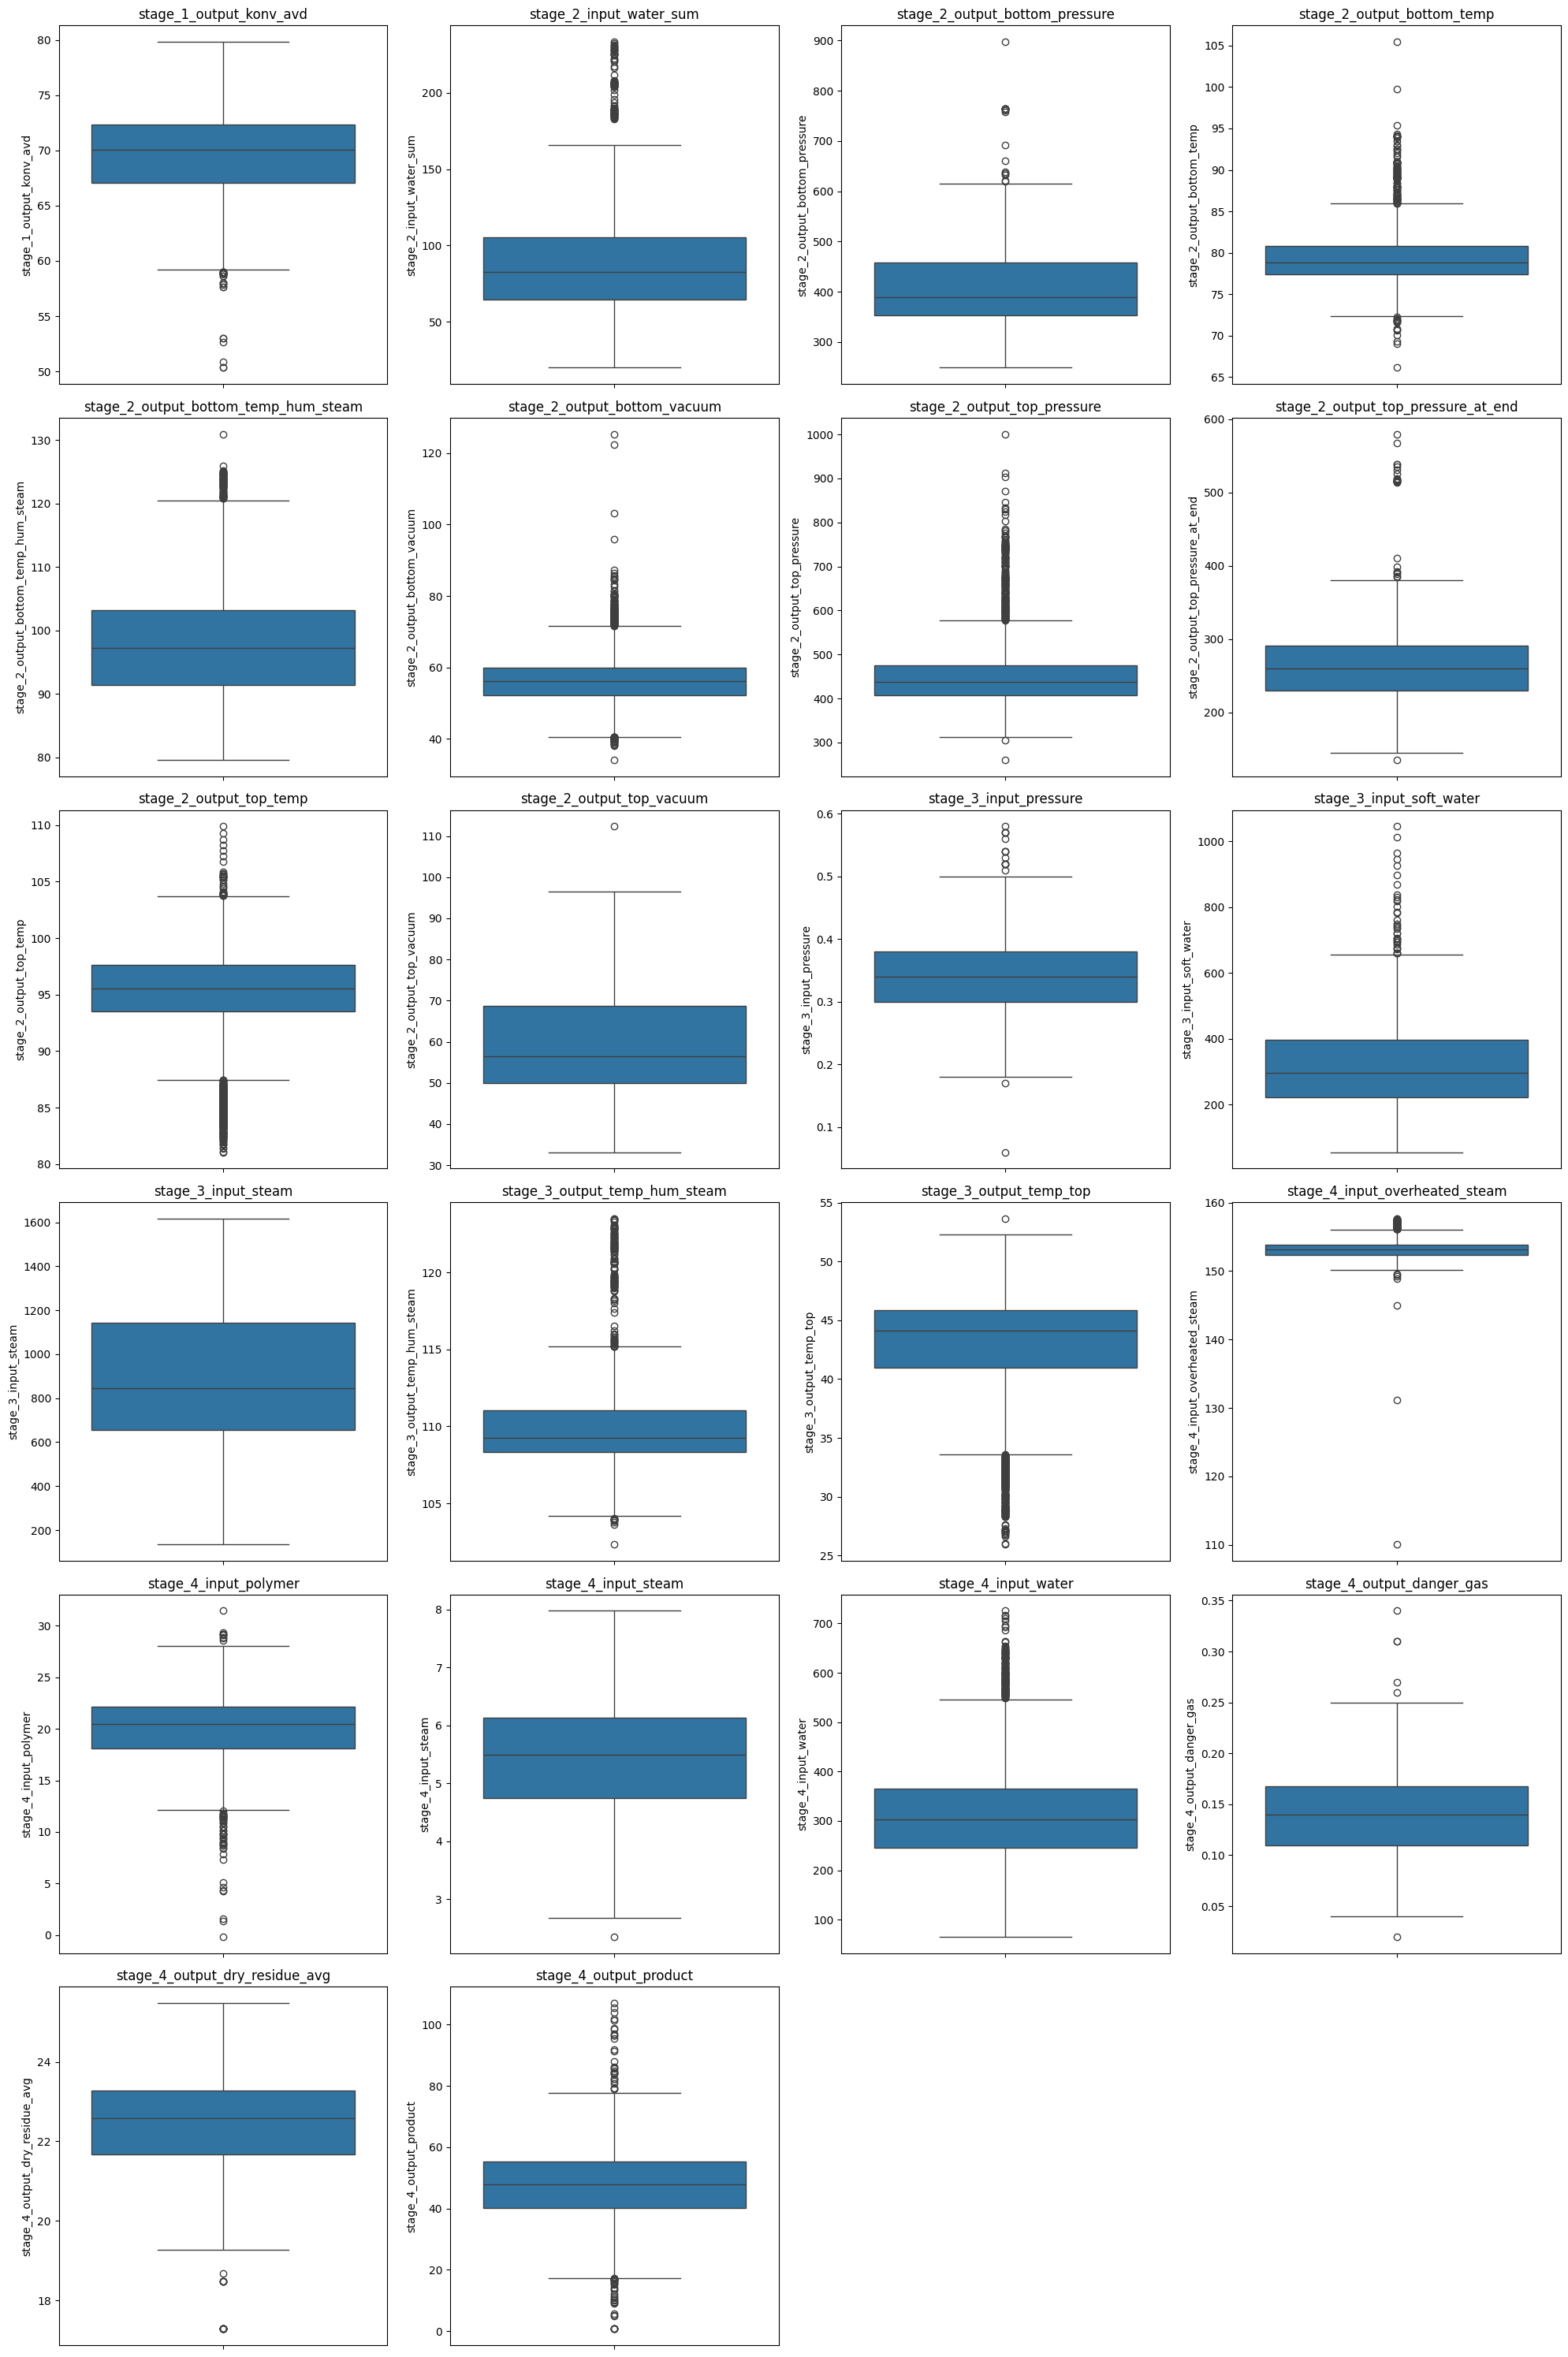

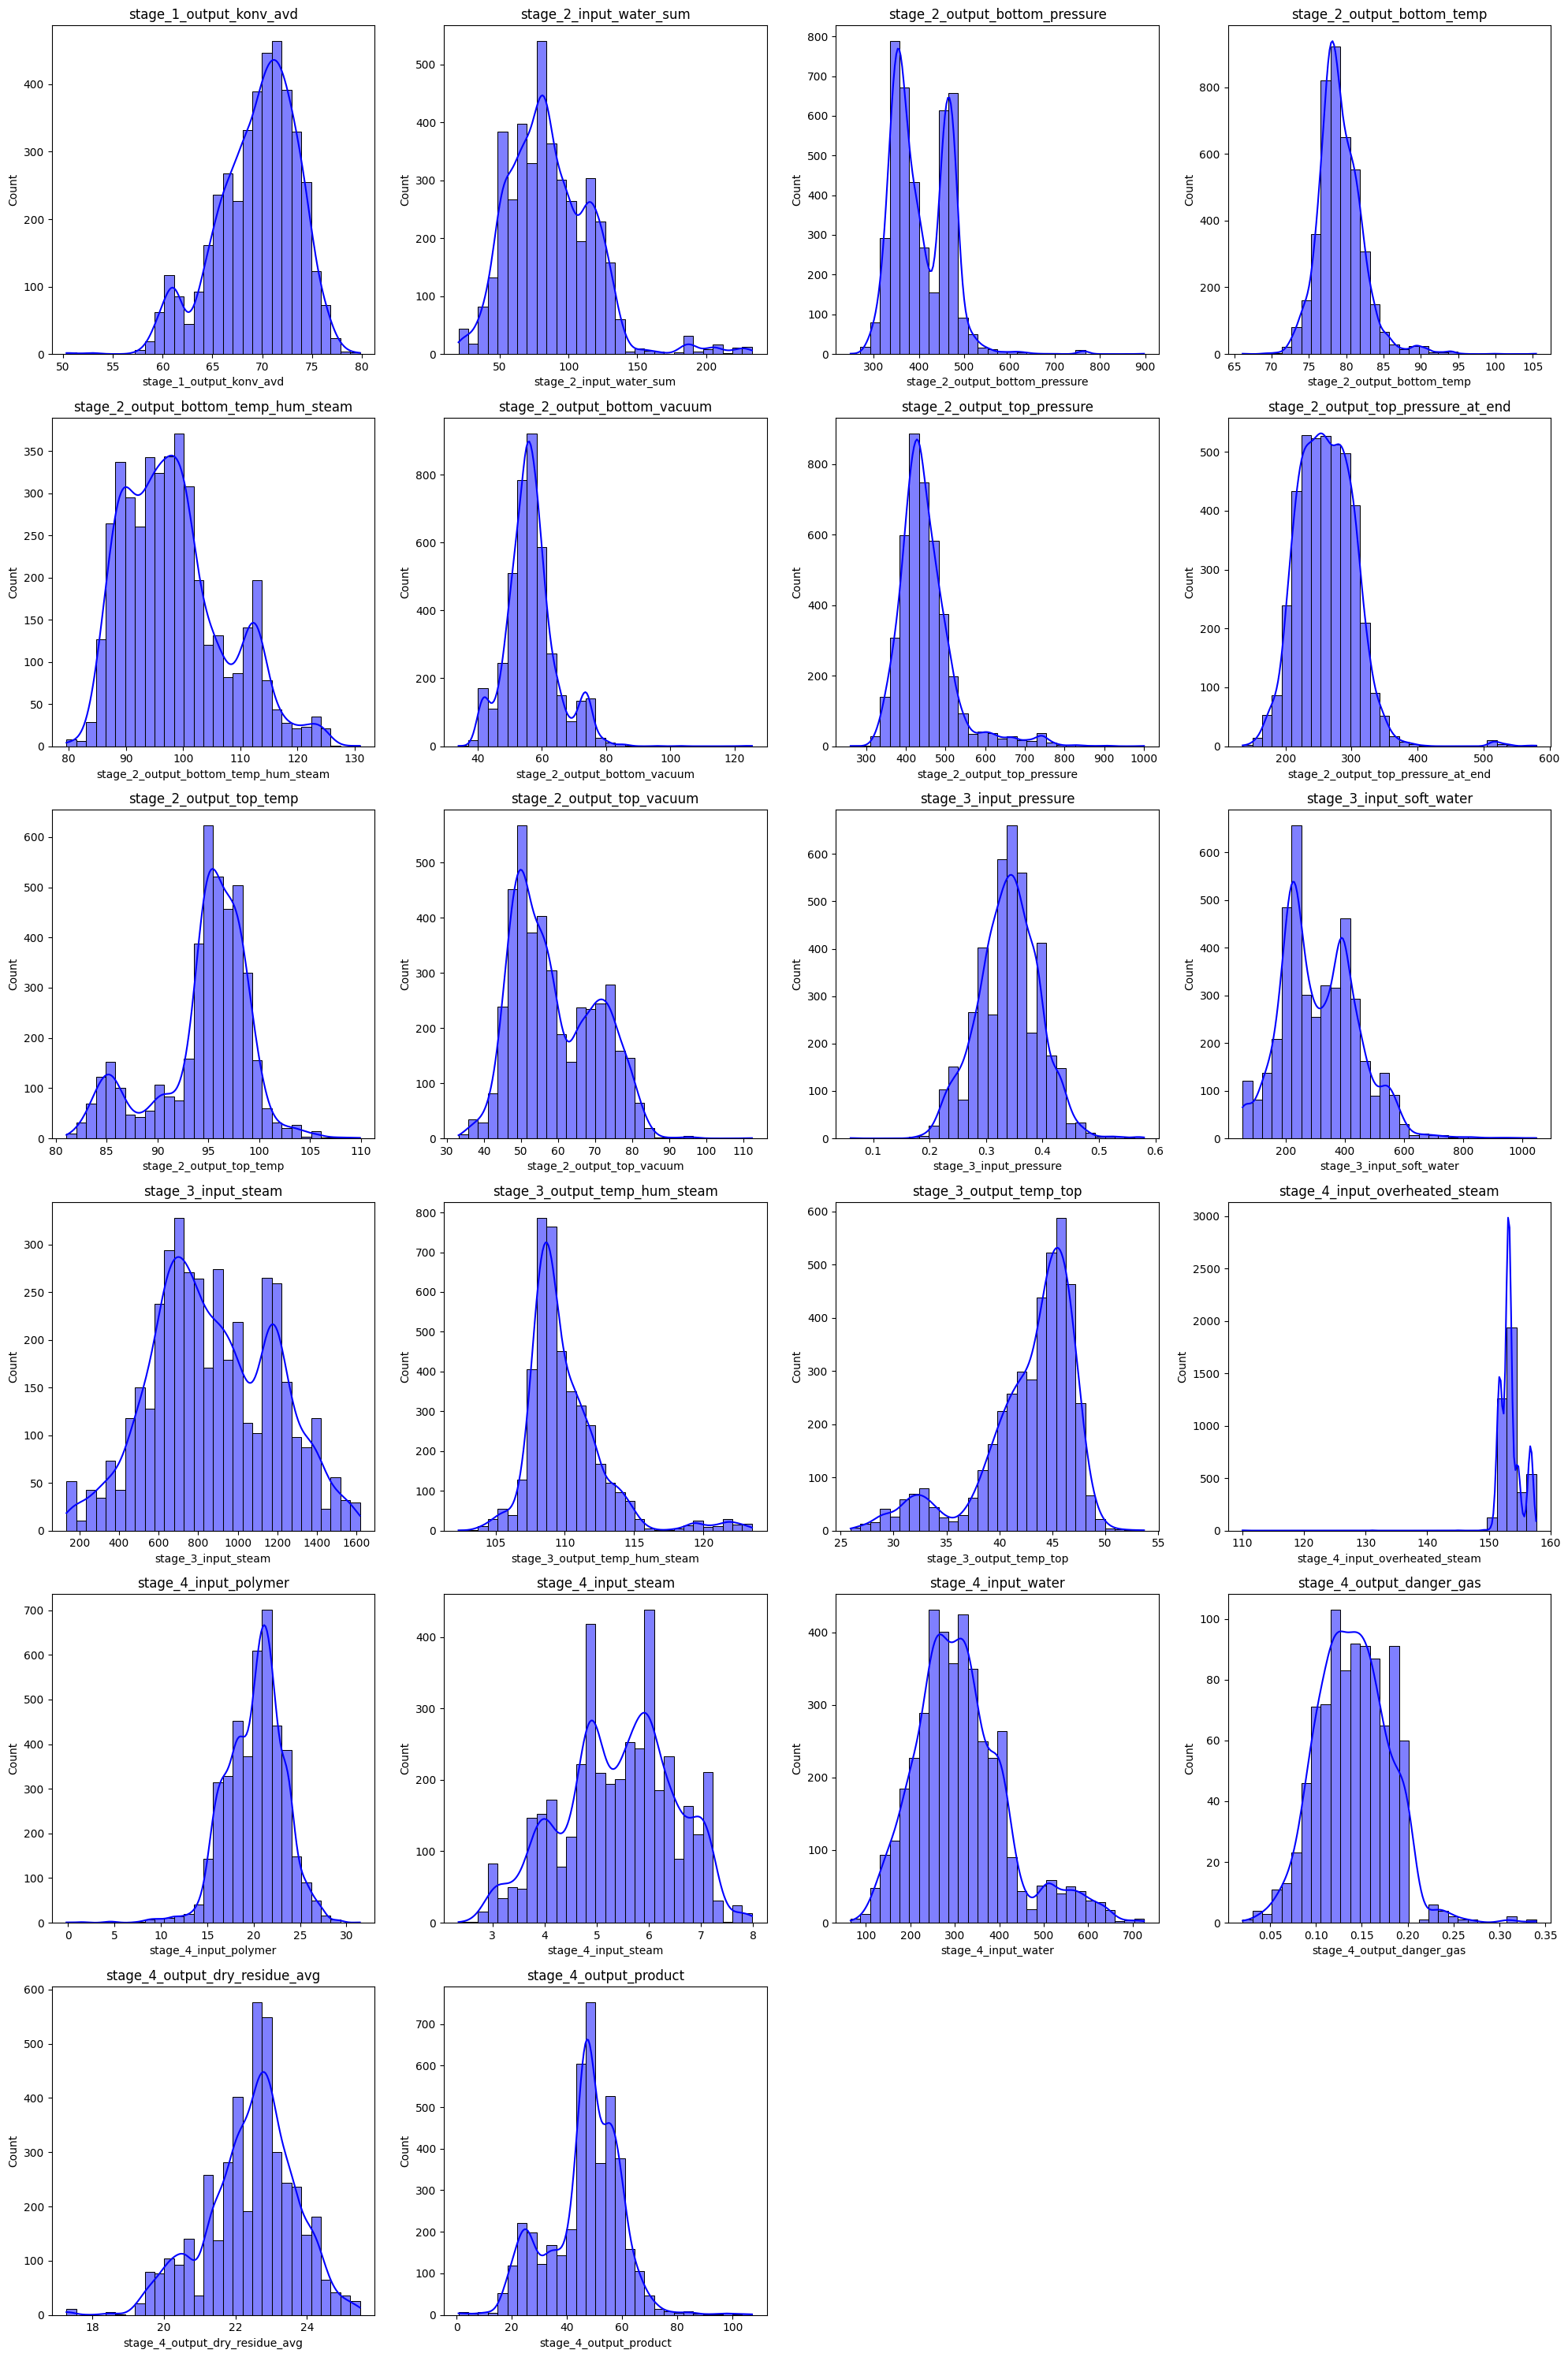

In [5]:
draw_boxplots_for_all_columns(df)
draw_histograms_for_all_columns(df)

Обработка выбросов.

In [7]:
columns_to_process = df.columns[1:-1]

print("Размер данных до обработки выбросов:", df.shape)
df = hybrid_outlier_handling(df, columns_to_process)
print("Размер данных после обработки выбросов:", df.shape)

Размер данных до обработки выбросов: (4400, 24)
Размер данных после обработки выбросов: (4400, 24)


Изобразим данные после обработки.

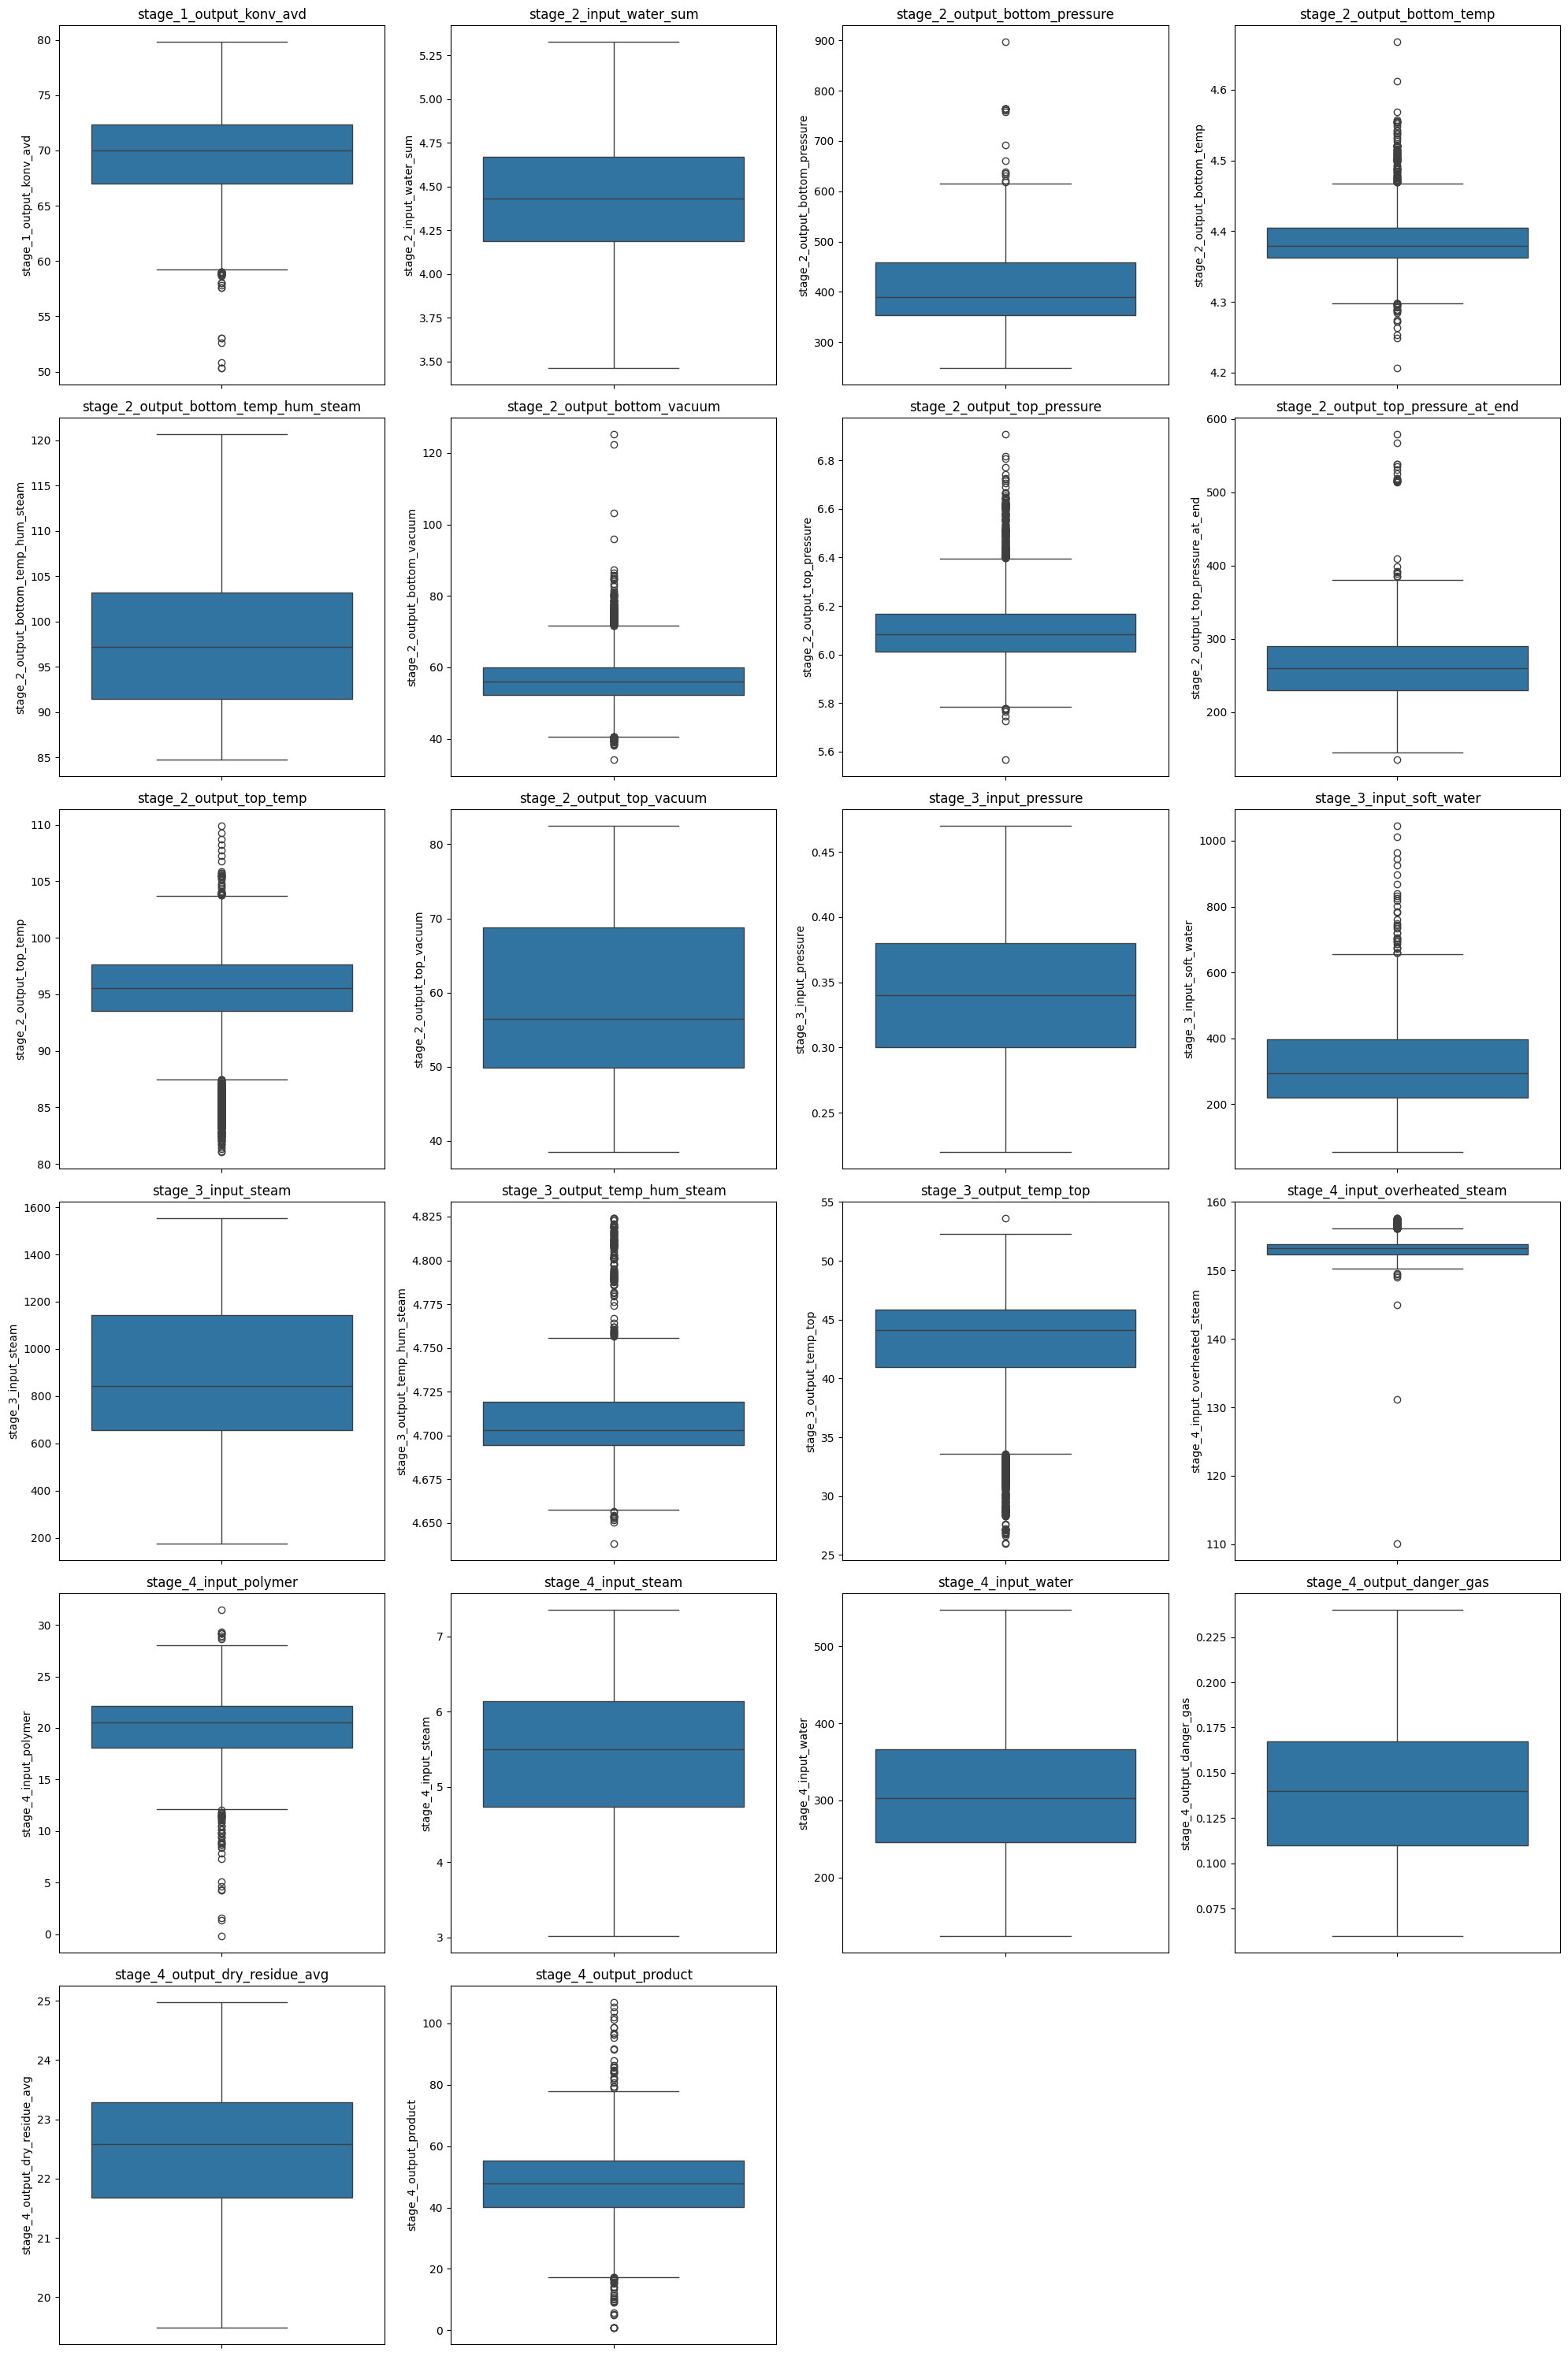

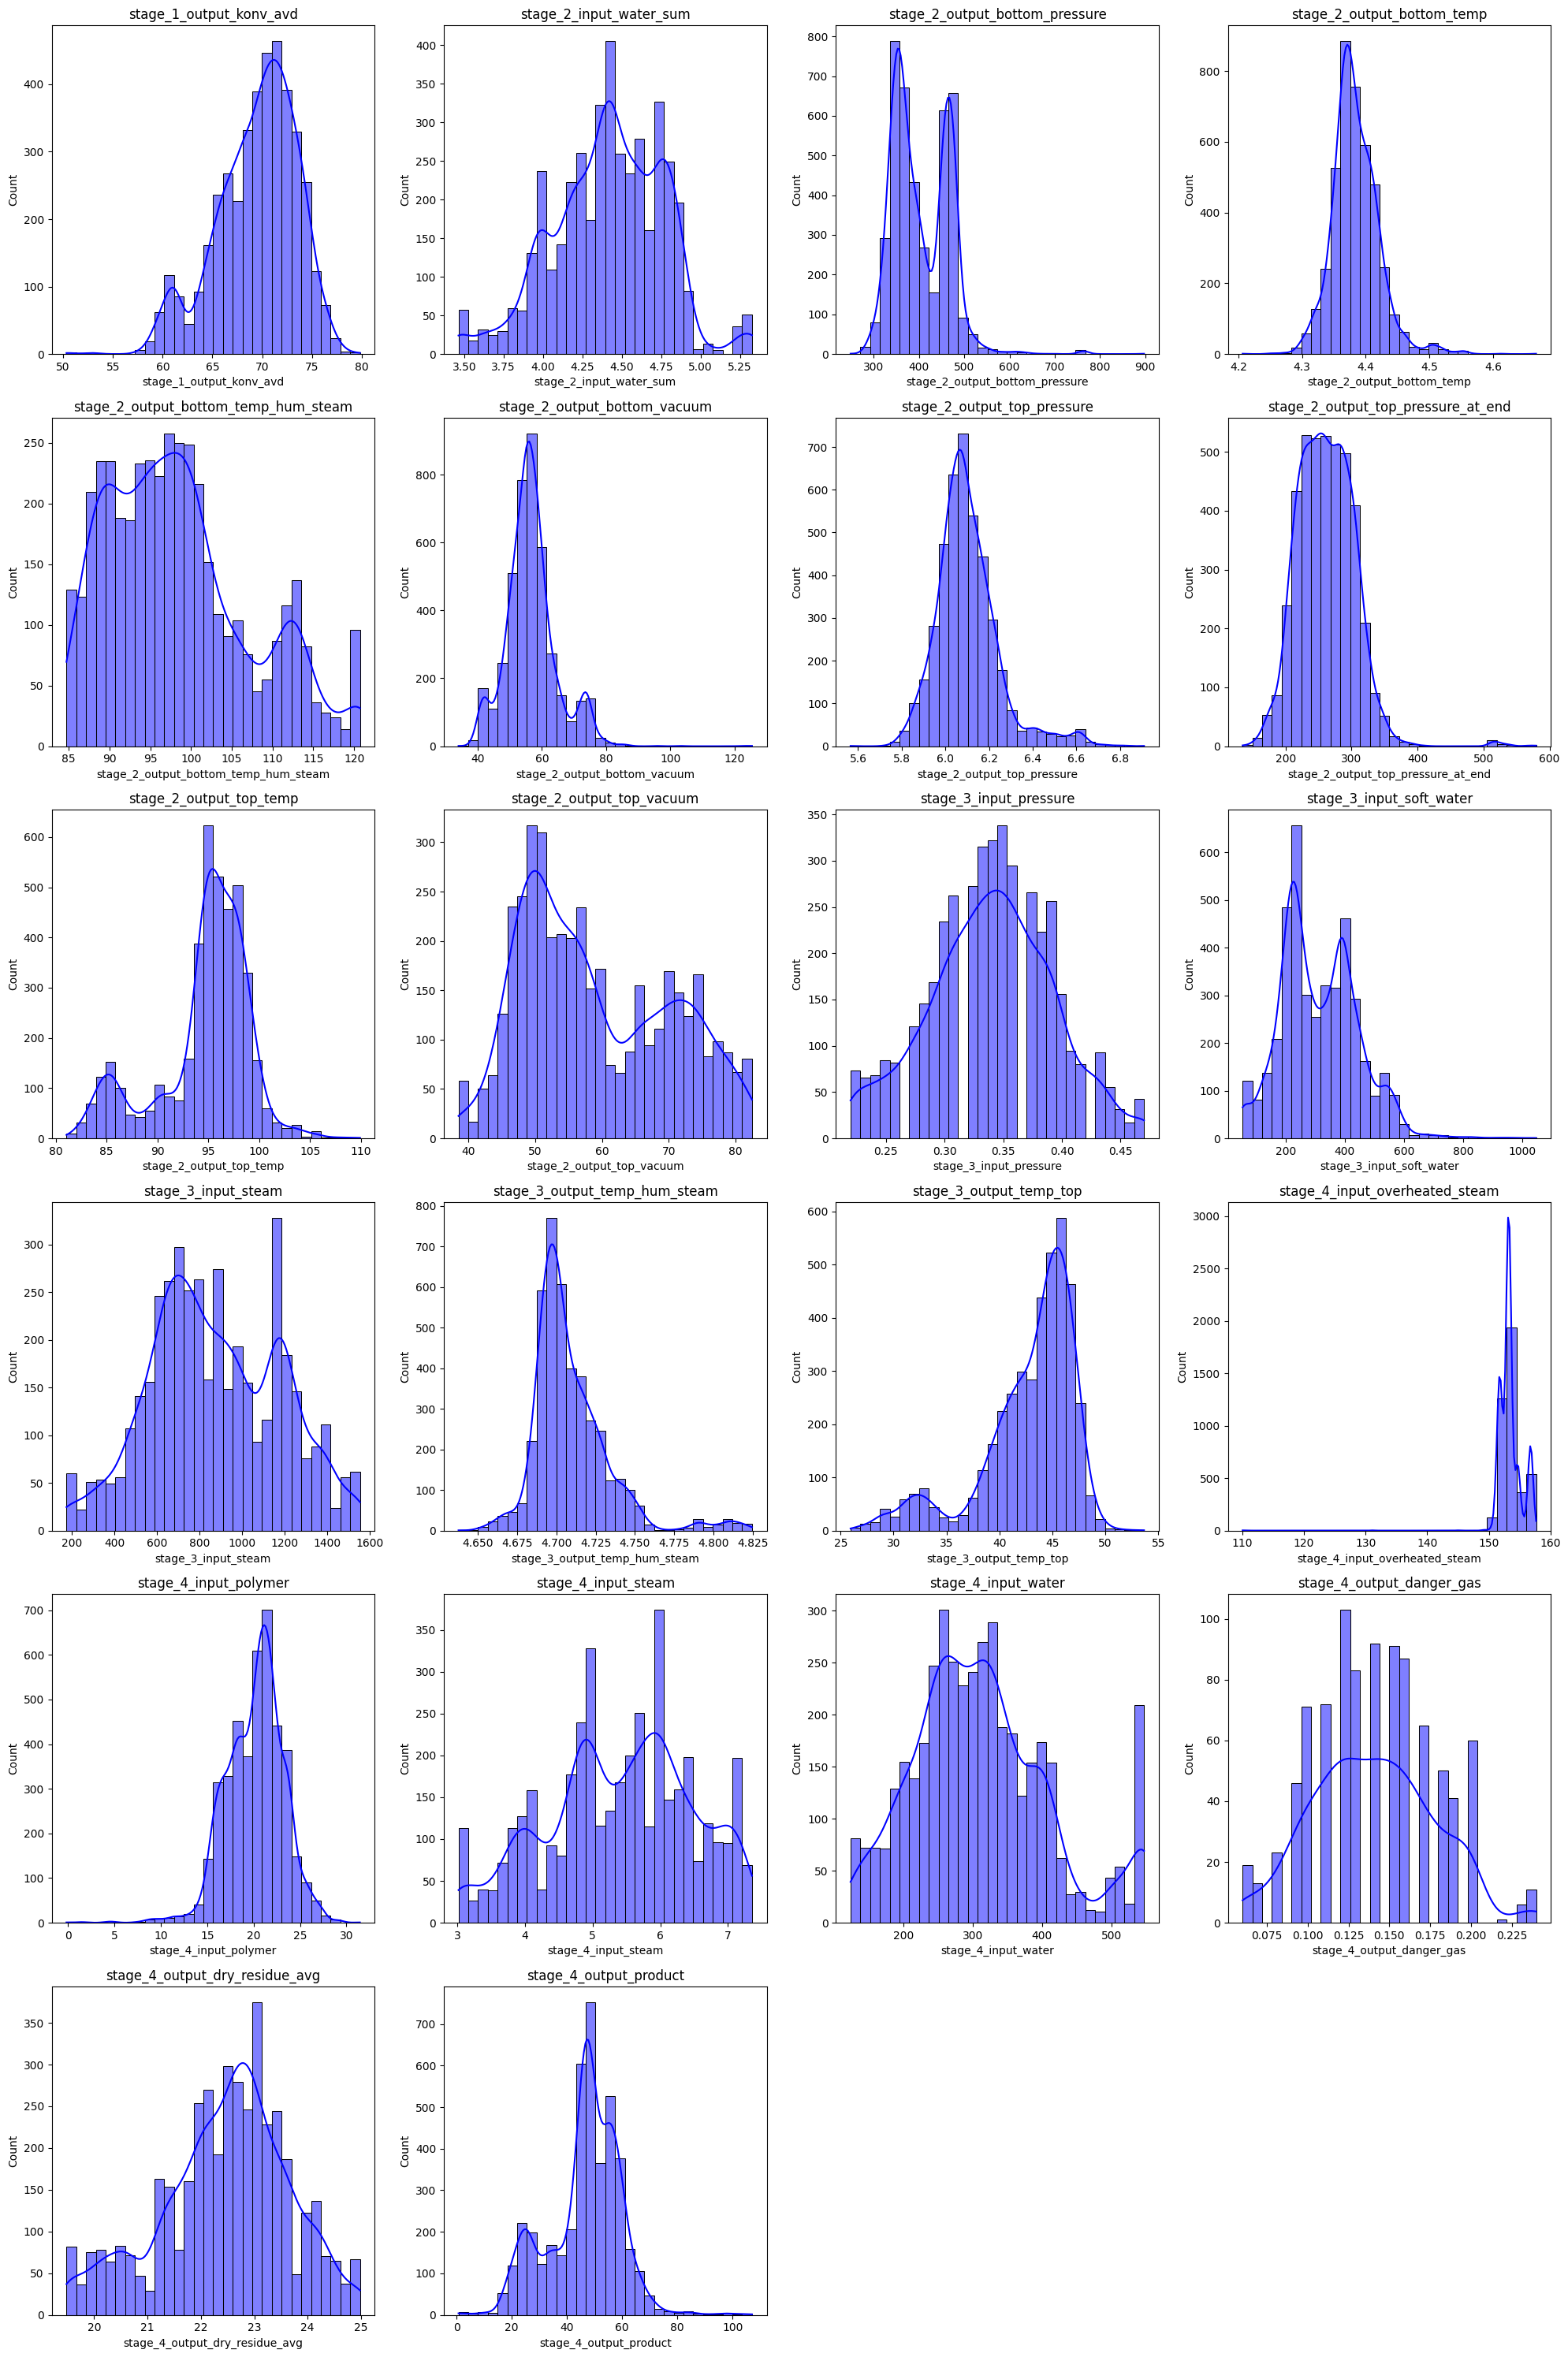

In [8]:
# Если нужно выделить графики колонок, добавьте их в список
# highlight_columns = []
draw_boxplots_for_all_columns(df)
draw_histograms_for_all_columns(df)